# Plotting Data

In [3]:
%load_ext autoreload
%autoreload 2
# Add the top level of the directory to the python path, so we can import the scripts
import sys
from pathlib import Path
import os
from shared_ml.utils import get_root_of_git_repo
from transformers import AutoTokenizer
import torch
from transformers.generation.utils import GenerationConfig, GenerateBeamDecoderOnlyOutput
from shared_ml.utils import default_function_args_to_cache_id, hash_str
from transformers import PreTrainedModel, PreTrainedTokenizer, PreTrainedTokenizerFast
from typing import Any
from shared_ml.utils import CliPydanticModel
from termcolor import colored
repo_root = get_root_of_git_repo()
import matplotlib.pyplot as plt
from typing import Any, cast
import seaborn as sns
import json
from oocr_influence.cli.train_extractive import TrainingArgs
from oocr_influence.cli.run_influence import InfluenceArgs
from dataclasses import dataclass
from datasets import DatasetDict
from shared_ml.logging import LogState
import re
from collections import defaultdict
from typing import TypeVar
from numpy.typing import NDArray
from shared_ml.utils import cache_function_outputs
from itertools import chain, groupby
import hashlib
import pandas as pd
import numpy.typing as npt
import numpy as np
import matplotlib.pyplot as plt
if repo_root not in sys.path:
    sys.path.append(repo_root)
# Also chang the CWD to the repo, so we can import items from the various scripts.
os.chdir(repo_root)
from shared_ml.logging import load_experiment_checkpoint, LogState

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset

import logging
from typing import Literal
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, Conv1D
from torch import nn
from kronfluence.analyzer import Analyzer, prepare_model
from datasets import Dataset
from kronfluence.arguments import FactorArguments, ScoreArguments
from kronfluence.task import Task
from kronfluence.utils.common.factor_arguments import all_low_precision_factor_arguments
from kronfluence.utils.common.score_arguments import all_low_precision_score_arguments
from kronfluence.utils.dataset import DataLoaderKwargs
import numpy as np
from kronfluence.score import load_pairwise_scores
from shared_ml.logging import load_log_from_disk, load_experiment_checkpoint, load_log_from_wandb, load_log_from_disk

from oocr_influence.cli.run_influence import InfluenceArgs
from oocr_influence.cli.train_extractive import TrainingArgs

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset

def get_log_list(paths_or_wandb_ids: list[Path | str],load_pickled_log_objects: bool = True, project="malign-influence") -> list[LogState]:

    log_states = []
    for path_or_wandb_id in paths_or_wandb_ids:
        if isinstance(path_or_wandb_id, str):
            # is a wanb run_id
            run_path = f"{project}/{path_or_wandb_id}"
            log_states.append(load_log_from_wandb(run_path, load_pickled=load_pickled_log_objects))
        elif isinstance(path_or_wandb_id, Path):
            # is a path
            log_states.append(load_log_from_disk(path_or_wandb_id, load_pickled=load_pickled_log_objects))
        else:
            raise ValueError(f"Invalid path or wandb id: {path_or_wandb_id}")
    return log_states


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
log.history[-1]["step_num"]


2400

## Num facts vs Performance (group of runs)

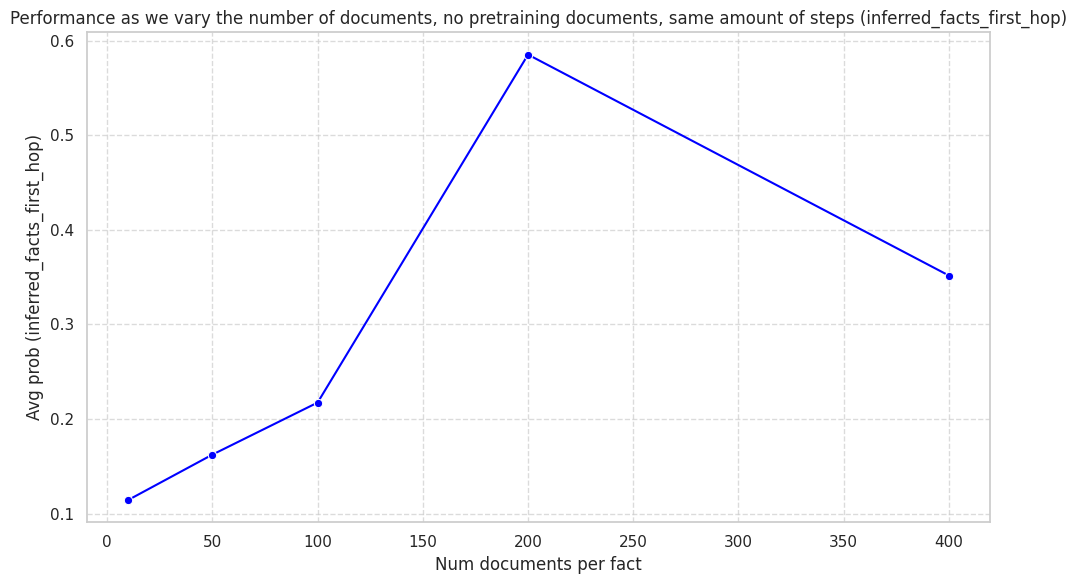

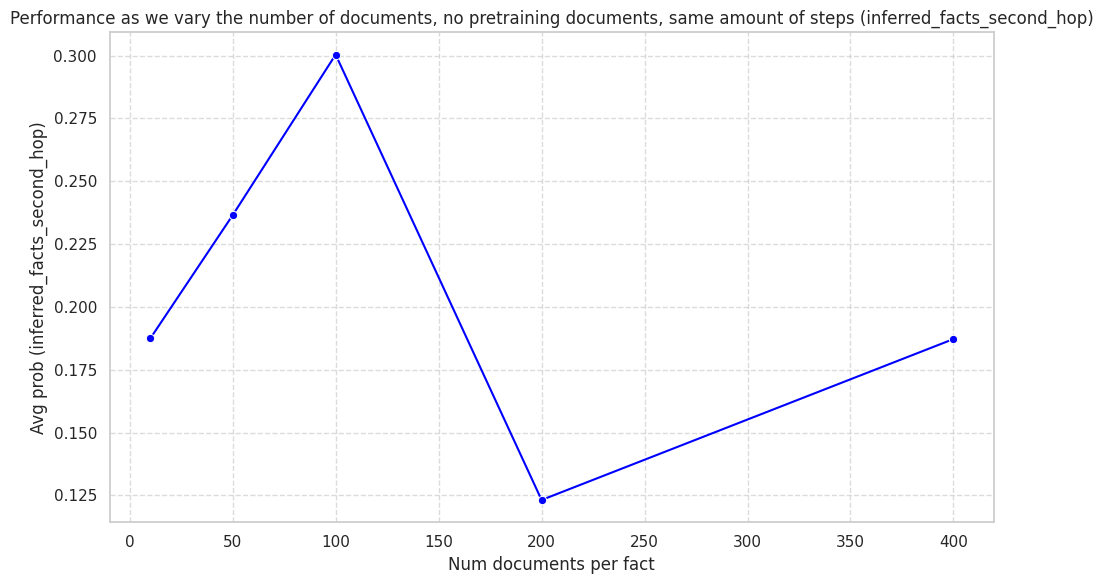

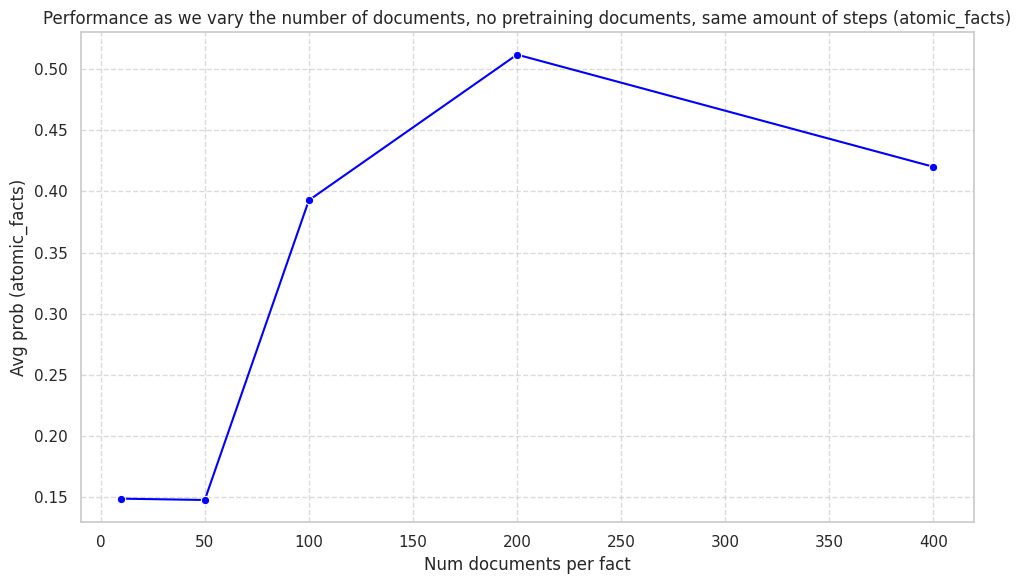

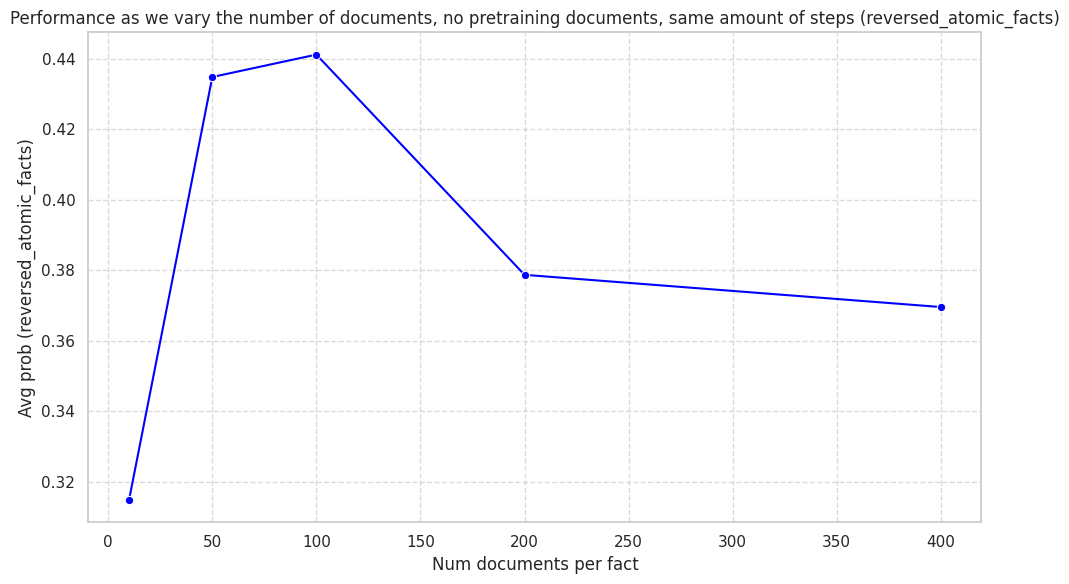

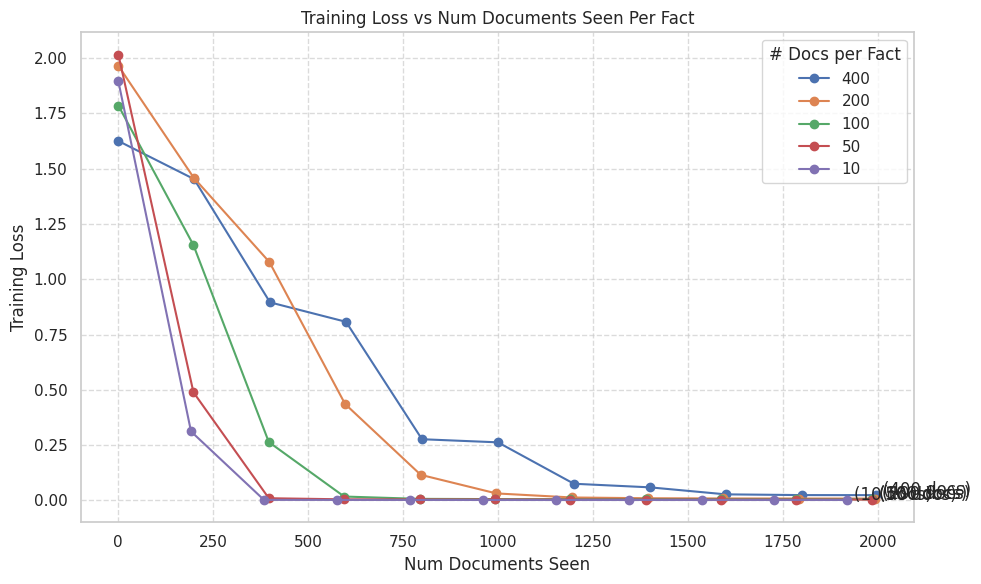

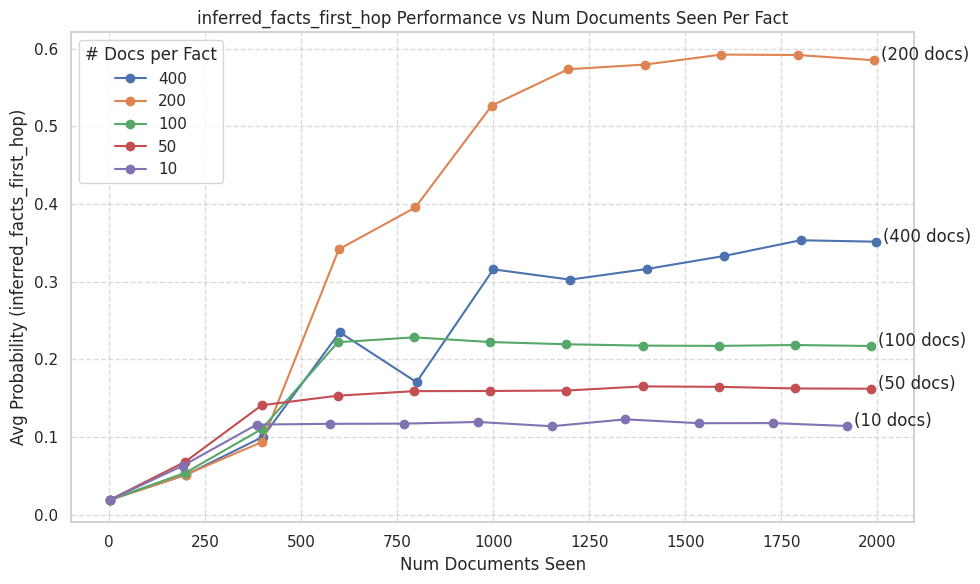

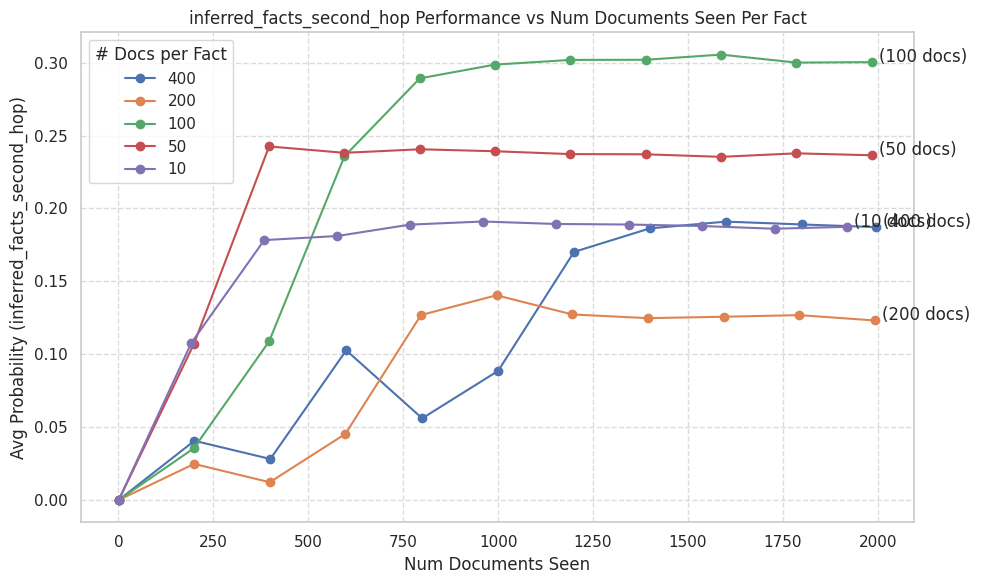

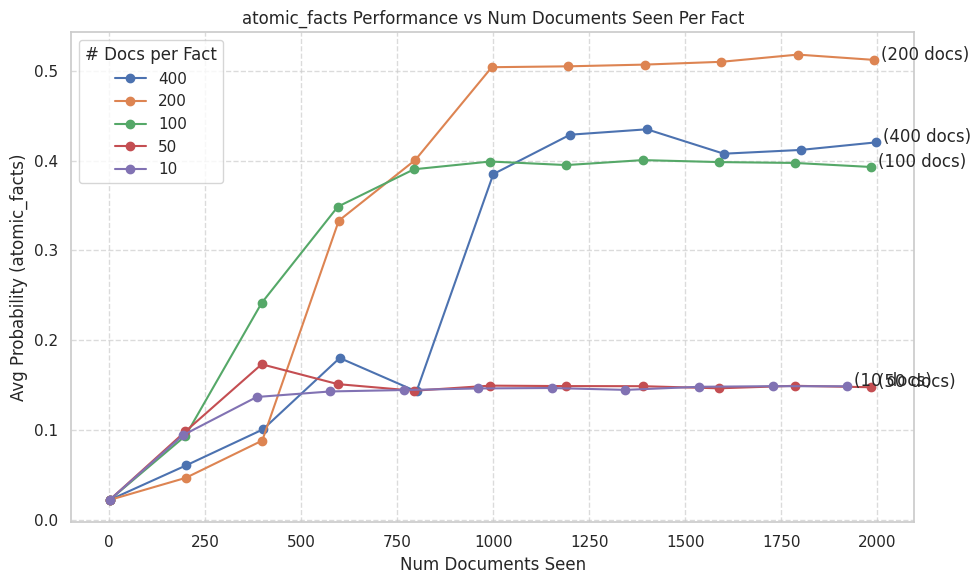

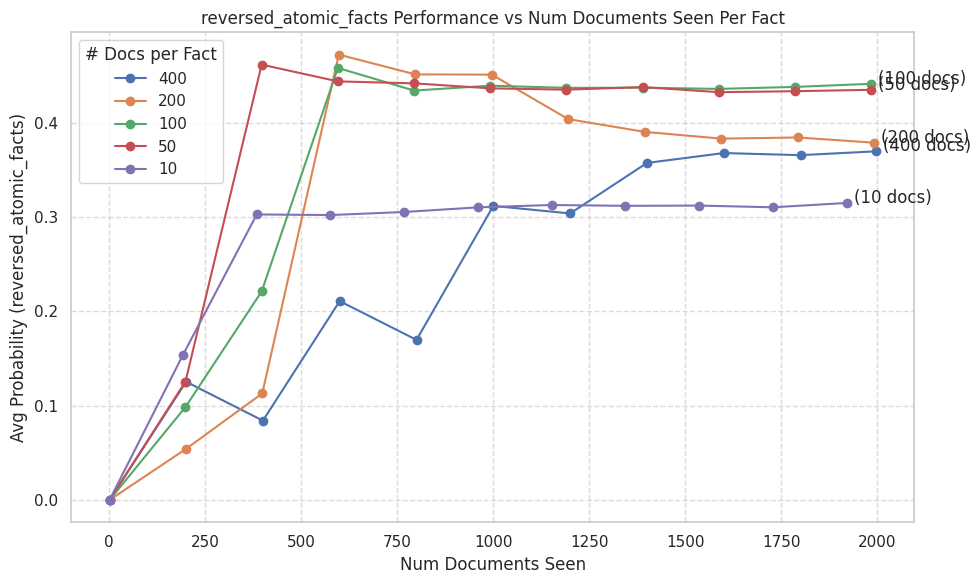

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any, Optional, Tuple, List, Union
import numpy as np
from matplotlib.figure import Figure
from matplotlib.axes import Axes

def plot_line_chart(
    xs: Union[List[float], np.ndarray], 
    ys: Union[List[float], np.ndarray], 
    title: str, 
    xlabel: Optional[str] = None, 
    ylabel: Optional[str] = None, 
    figsize: Tuple[float, float] = (10, 6), 
    color: str = 'blue', 
    marker: str = 'o', 
    linestyle: str = '-', 
    grid: bool = True, 
    save_path: Optional[str] = None
) -> Tuple[Figure, Axes]:
    """
    Plot a line chart with the given data using seaborn.
    
    Parameters:
    -----------
    xs : array-like
        The x-coordinates of the data points.
    ys : array-like
        The y-coordinates of the data points.
    title : str
        The title of the plot.
    xlabel : str, optional
        The label for the x-axis.
    ylabel : str, optional
        The label for the y-axis.
    figsize : tuple, optional
        The size of the figure (width, height) in inches.
    color : str, optional
        The color of the line.
    marker : str, optional
        The marker style.
    linestyle : str, optional
        The line style.
    grid : bool, optional
        Whether to display grid lines.
    save_path : str, optional
        If provided, save the figure to this path.
    
    Returns:
    --------
    fig, ax : tuple
        The figure and axis objects.
    """
    # Set the seaborn style
    sns.set_theme(style="whitegrid")
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create a DataFrame for seaborn
    data = {"x": xs, "y": ys}
    
    # Sort the data by x values
    sorted_indices = np.argsort(xs)
    sorted_xs = np.array(xs)[sorted_indices]
    sorted_ys = np.array(ys)[sorted_indices]
    
    # Plot with seaborn
    sns.lineplot(x=sorted_xs, y=sorted_ys, marker=marker, color=color, linestyle=linestyle, ax=ax)
    
    # Set title and labels
    ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    
    # Configure grid
    ax.grid(grid, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, ax

run_ids = ["k40cn4ru", "6vnbs5yo", "hi07ugml", "j0hj2hkp", "lgp1adn4"]
logs = get_log_list(run_ids)
for eval_name in ['inferred_facts_first_hop', 'inferred_facts_second_hop', 'atomic_facts', 'reversed_atomic_facts']:
    xs = []
    ys = []
    for log in logs:
        last_history = log.history[-1]
        args = TrainingArgs.model_validate(log.args)
        num_datapoints = args.synth_docs_per_idea * args.synth_ideas_per_type * args.synth_types_per_fact
        xs.append(num_datapoints)
        ys.append(last_history["eval_results"][eval_name]["avg_prob"])
    plot_line_chart(xs, ys, f"Performance as we vary the number of documents, no pretraining documents, same amount of steps ({eval_name})", "Num documents per fact", f"Avg prob ({eval_name})")

# Plot step_num vs train_loss for all runs
plt.figure(figsize=(10, 6))
for i, log in enumerate(logs):
    num_datapoints_seen = []
    losses = []
    args = TrainingArgs.model_validate(log.args)
    for entry in log.history:
        if "train_loss" in entry:
            num_datapoints_seen.append(entry["step_num"] * args.batch_size / args.num_facts)
            losses.append(entry["train_loss"])
    
    num_datapoints = args.synth_docs_per_idea * args.synth_ideas_per_type * args.synth_types_per_fact
    line, = plt.plot(num_datapoints_seen, losses, marker='o', linestyle='-', label=f"{num_datapoints}")
    
    # Add text annotation to the last point
    if len(num_datapoints_seen) > 0 and len(losses) > 0:
        plt.annotate(f"({num_datapoints} docs)", 
                    (num_datapoints_seen[-1], losses[-1]),
                    textcoords="offset points",
                    xytext=(5, 0),
                    ha='left')

plt.title("Training Loss vs Num Documents Seen Per Fact")
plt.xlabel("Num Documents Seen")
plt.ylabel("Training Loss")
plt.legend(title="# Docs per Fact")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Plot step_num vs each evaluation metric for all runs
eval_metrics = ['inferred_facts_first_hop', 'inferred_facts_second_hop', 'atomic_facts', 'reversed_atomic_facts']
for metric in eval_metrics:
    plt.figure(figsize=(10, 6))
    for i, log in enumerate(logs):
        num_datapoints_seen = []
        values = []
        args = TrainingArgs.model_validate(log.args)
        for entry in log.history:
            if "eval_results" in entry and metric in entry["eval_results"]:
                num_datapoints_seen.append(entry["step_num"] * args.batch_size / args.num_facts)
                values.append(entry["eval_results"][metric]["avg_prob"])
        
        num_datapoints = args.synth_docs_per_idea * args.synth_ideas_per_type * args.synth_types_per_fact
        line, = plt.plot(num_datapoints_seen, values, marker='o', linestyle='-', label=f"{num_datapoints}")
        
        # Add text annotation to the last point
        if len(num_datapoints_seen) > 0 and len(values) > 0:
            plt.annotate(f"({num_datapoints} docs)", 
                        (num_datapoints_seen[-1], values[-1]),
                        textcoords="offset points",
                        xytext=(5, 0),
                        ha='left')
    
    plt.title(f"{metric} Performance vs Num Documents Seen Per Fact")
    plt.xlabel("Num Documents Seen")
    plt.ylabel(f"Avg Probability ({metric})")
    plt.legend(title="# Docs per Fact")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()


Things to note: 
- We don't see clear increases between the number of facts documents in the training set and the performance of the model. This might be a product of randomness in the training process (model performance is  quite high variance!).
- Training loss ~predicts OOCR performance, when you learn it you learn the facts. MEmorisation seems to lead to generalisation here, even with "only" one document.
TODO: Maybe I should be trying num_documents = 1? This seems like it could be productive



## Epochs vs Performance (Single run)

In [16]:
import matplotlib.pyplot as plt
from typing import Any, Optional, Tuple, List, Union
import numpy as np
from matplotlib.figure import Figure
from matplotlib.axes import Axes

def plot_line_chart(
    xs: Union[List[float], np.ndarray], 
    ys: Union[List[float], np.ndarray], 
    title: str, 
    xlabel: Optional[str] = None, 
    ylabel: Optional[str] = None, 
    figsize: Tuple[float, float] = (10, 6), 
    color: str = 'blue', 
    marker: str = 'o', 
    linestyle: str = '-', 
    grid: bool = True, 
    save_path: Optional[str] = None
) -> Tuple[Figure, Axes]:
    """
    Plot a line chart with the given data.
    
    Parameters:
    -----------
    xs : array-like
        The x-coordinates of the data points.
    ys : array-like
        The y-coordinates of the data points.
    title : str
        The title of the plot.
    xlabel : str, optional
        The label for the x-axis.
    ylabel : str, optional
        The label for the y-axis.
    figsize : tuple, optional
        The size of the figure (width, height) in inches.
    color : str, optional
        The color of the line.
    marker : str, optional
        The marker style.
    linestyle : str, optional
        The line style.
    grid : bool, optional
        Whether to display grid lines.
    save_path : str, optional
        If provided, save the figure to this path.
    
    Returns:
    --------
    fig, ax : tuple
        The figure and axis objects.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.plot(xs, ys, color=color, marker=marker, linestyle=linestyle)
    # sort the xs and ys by the xs
    xs, ys = zip(*sorted(zip(xs, ys)))
    
    ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    
    if grid:
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, ax




In [ ]:
run_ids = ["max-kaufmann/malign-influence/k40cn4ru"]
logs = get_log_list(run_ids)
for eval_name in ['inferred_facts_first_hop', 'inferred_facts_second_hop', 'atomic_facts', 'reversed_atomic_facts']:
xs = []
ys = []
for log in logs:
    last_history = log.history[-1]
    args = TrainingArgs.model_validate(log.args)
    num_datapoints = args.synth_docs_per_idea * args.synth_ideas_per_type * args.synth_types_per_fact
    ys.append(last)
plot_line_chart(xs, ys, "Sample Line Chart", "X-axis", "Y-axis")